In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import timm

from PIL import Image

In [3]:
class HAM10000Dataset(torch.utils.data.Dataset):
    """Custom Dataset for HAM10000 with metadata."""
    
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        
        # Map diagnosis to numeric labels
        self.label_map = {
            'akiec': 0,  # Actinic keratoses
            'bcc': 1,    # Basal cell carcinoma
            'bkl': 2,    # Benign keratosis
            'df': 3,     # Dermatofibroma
            'mel': 4,    # Melanoma
            'nv': 5,     # Melanocytic nevi
            'vasc': 6    # Vascular lesions
        }
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row["image_id"]
        
        # Try different image directories (HAM10000 splits images into folders)
        img_path = None
        for folder in ["HAM10000_images_part_1", "HAM10000_images_part_2", "HAM10000_images"]:
            path = os.path.join(self.img_dir, folder, f"{img_id}.jpg")
            if os.path.exists(path):
                img_path = path
                break
        
        if img_path is None:
            # Fallback to direct path
            img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
        
        image = Image.open(img_path).convert("RGB")
        label = self.label_map[row["dx"]]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

metadata_path = "../dataverse_files/HAM10000_metadata"
data_dir = "../dataverse_files"
df = pd.read_csv(metadata_path)

# Remove duplicates (HAM10000 has duplicate images)
df_unique = df.drop_duplicates(subset=["image_id"])

# Class distribution
class_counts = df_unique["dx"].value_counts()

# Stratified split
train_df, val_df = train_test_split(
    df_unique, test_size=0.2, stratify=df_unique["dx"], random_state=42
)

val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_dataset = HAM10000Dataset(val_df, data_dir, transform=val_transform)

checkpoint = torch.load("./models/ham10000_efficientnet_b4.pth", map_location=device)

model = timm.create_model(
    "tf_efficientnet_b4",
    pretrained=False,  # ImageNet weights
    num_classes=7,
)

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNo

In [8]:
# Compute class weights for weighted sampling
label_map = {"akiec": 0, "bcc": 1, "bkl": 2, "df": 3, "mel": 4, "nv": 5, "vasc": 6}
labels = train_df["dx"].map(label_map).values
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(labels), y=labels
)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))

all_labels = []
all_preds = []
all_probs = []

val_loss_batches = []
val_acc_batches = []

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=12,
    pin_memory=torch.cuda.is_available(),
)
    

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        # Probabilities and predictions
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        # Batch accuracy
        correct = (preds == labels).sum().item()
        acc = correct / labels.size(0)

        val_loss_batches.append(loss.item())
        val_acc_batches.append(acc)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

In [9]:
avg_val_loss = float(np.mean(val_loss_batches))
avg_val_acc = float(np.mean(val_acc_batches))

precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

print(f"Val loss: {avg_val_loss:.4f}")
print(f"Val accuracy: {avg_val_acc:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 (macro): {f1:.4f}")

Val loss: 0.6587
Val accuracy: 0.6861
Precision (macro): 0.5697
Recall (macro): 0.8033
F1 (macro): 0.6403


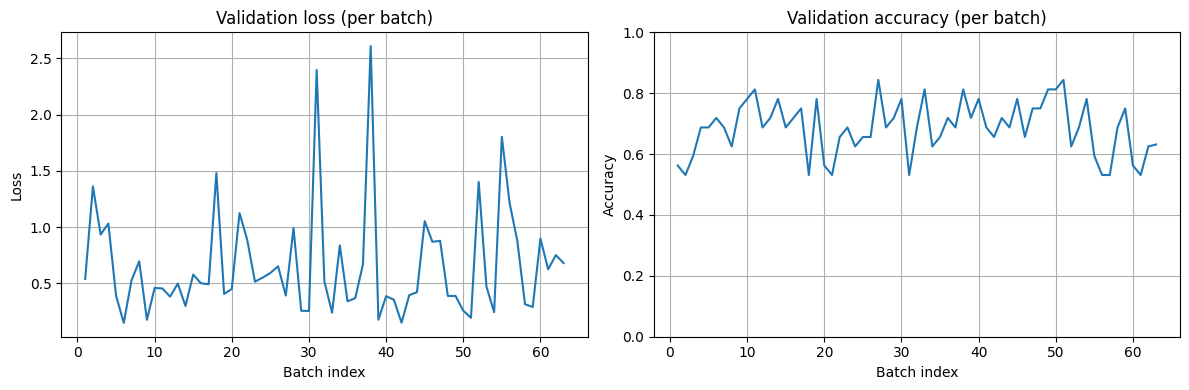

In [10]:
epochs_or_steps = range(1, len(val_loss_batches) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_or_steps, val_loss_batches, label="Val loss")
plt.xlabel("Batch index")
plt.ylabel("Loss")
plt.title("Validation loss (per batch)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_or_steps, val_acc_batches, label="Val accuracy")
plt.xlabel("Batch index")
plt.ylabel("Accuracy")
plt.title("Validation accuracy (per batch)")
plt.ylim(0, 1)
plt.grid(True)

plt.tight_layout()
plt.show()

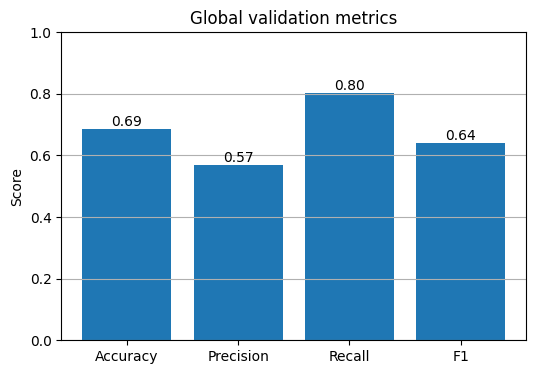

In [11]:
metrics_names = ["Accuracy", "Precision", "Recall", "F1"]
metrics_values = [avg_val_acc, precision, recall, f1]

plt.figure(figsize=(6, 4))
plt.bar(metrics_names, metrics_values)
plt.ylim(0, 1)
for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")
plt.title("Global validation metrics")
plt.ylabel("Score")
plt.grid(axis="y")
plt.show()

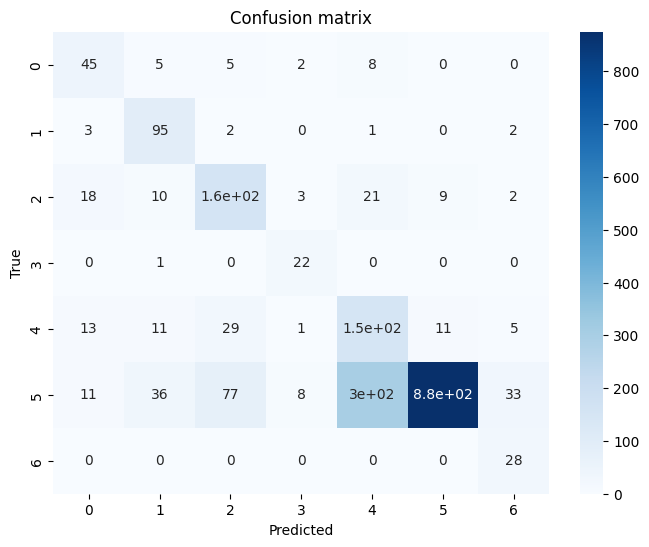

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix")
plt.show()